In [1]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

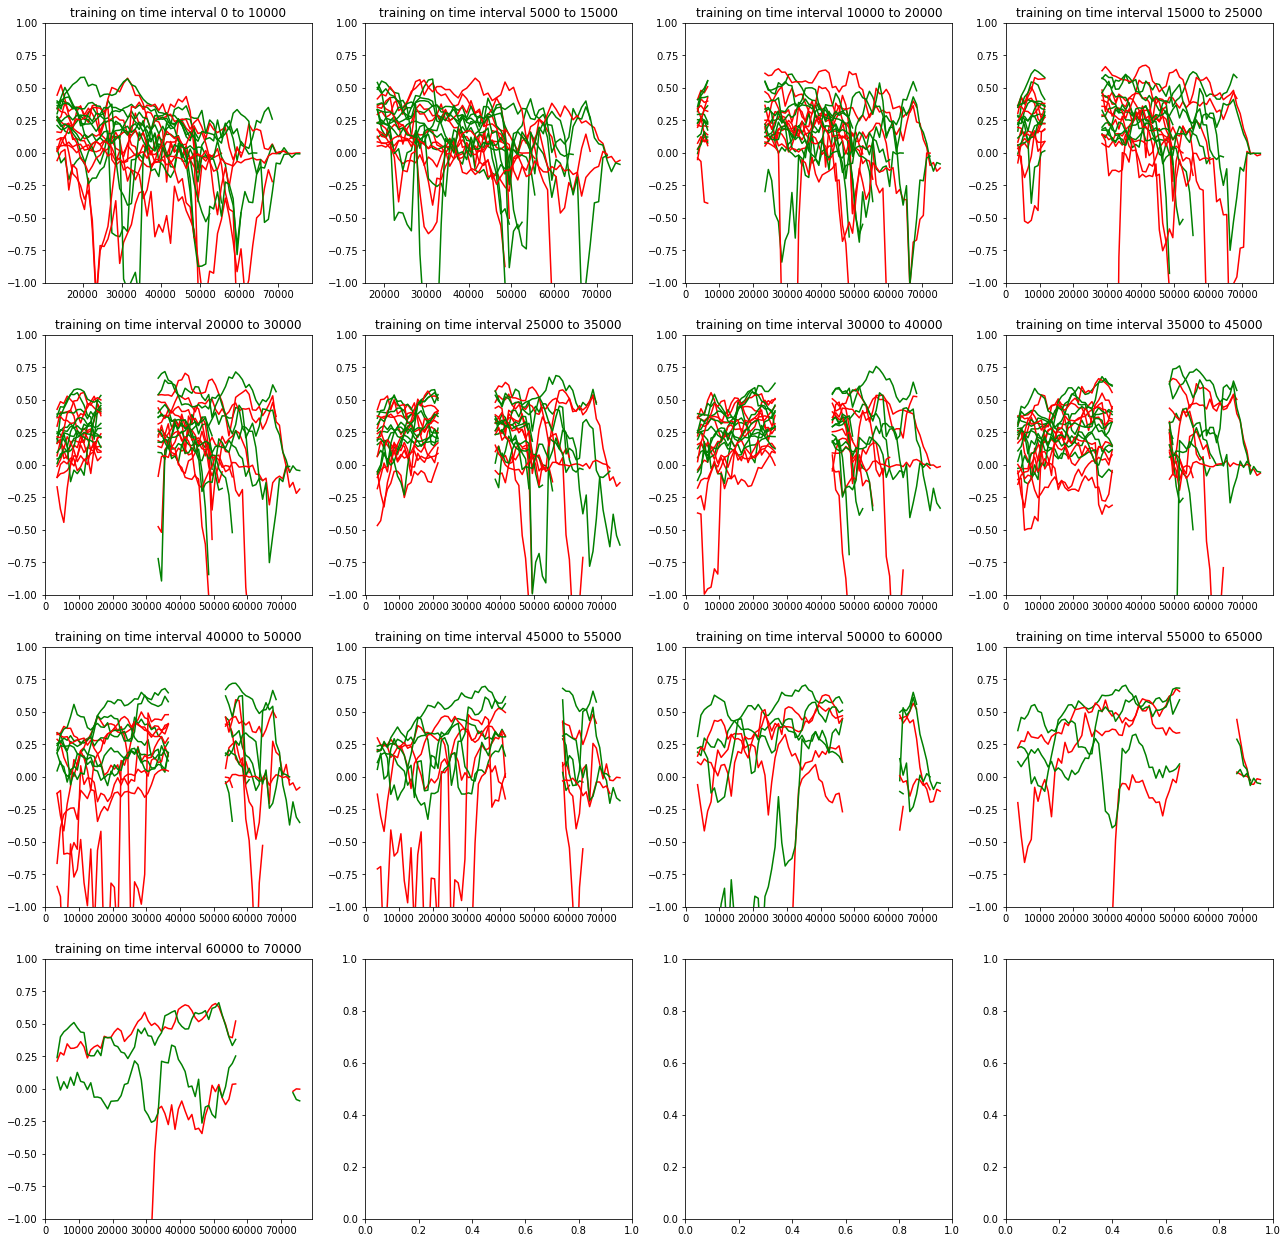

In [2]:

store_dir = '../DATA/FILES/'

fig, axs = plt.subplots(4,4,figsize=(22,22))

file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
alldat = pickle.load(file)

all_time_pos_positive = [ [] for _ in range(13) ]
all_time_pos_negative = [ [] for _ in range(13) ]
pos_corr = []
neg_corr = []
all_rats = list(alldat.keys())
for rat in all_rats:  
    all_days = list(alldat[rat].keys())
    for day in all_days:
        ##print(rat, day)
        
        inst_fr = np.load(store_dir + rat + '_' + day + '_inst_fr.npy')
        x = np.load(store_dir + rat + '_' + day + '_x_within.npy')
        y = np.load(store_dir + rat + '_' + day + '_y_within.npy')
        
        scaler = StandardScaler()
        inst_fr = scaler.fit_transform(inst_fr)

        dt = 5000##10000
        train_size = 10000##16000
        buffer = 1000
        test_size = 5000
        window = 1000

        for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
            ##print(len(inst_fr))
            ##print('starting',i*dt, i*dt+ train_size)
            all_test_scores= []
            all_test_scores_other = []

            X_train = inst_fr[i*dt: (i)*dt+ train_size]
            y_train1 = x[i*dt: (i)*dt+ train_size]
            y_train2 = y[i*dt: (i)*dt+ train_size]

            model = LinearRegression()
            model.fit(X_train, y_train1)

            model2 = LinearRegression()
            model2.fit(X_train, y_train2)

            start = (i)*dt+ train_size + buffer 
            all_mids = []
            xtest_scores = []
            ytest_scores = []
            while start + window + test_size < len(inst_fr):
                ##print(start, start + test_size)
                xscore = model.score( inst_fr[start: start + test_size],x[start: start + test_size])
                xtest_scores.append(xscore)
                yscore = model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size])
                ytest_scores.append(yscore)
                all_mids.append((start + start + test_size)/2)
                all_time_pos_negative[i].append(np.array([(start + start + test_size)/2, xscore]))
                start = start + window
            
            if len(all_mids)>5:
                neg_corr.append(scipy.stats.spearmanr(all_mids, xtest_scores)[0])
                ##neg_corr.append(scipy.stats.spearmanr(all_mids, np.maximum(xtest_scores,0))[0])


            all_mids_other = []
            start = (i)*dt- buffer-test_size 

            xtest_scores_other = []
            ytest_scores_other = []
            while start >0:
                ##print('early', start, start+test_size)
                xscore = model.score(inst_fr[start: start + test_size],x[start: start + test_size])
                xtest_scores_other.append(xscore)
                yscore = model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size])
                ytest_scores_other.append(yscore)
                all_mids_other.append((start + start + test_size)/2)
                all_time_pos_positive[i].append(np.array([(start + start + test_size)/2, xscore]))
                start = start - window
            if len(all_mids_other)>5:
                pos_corr.append(scipy.stats.spearmanr(all_mids_other, xtest_scores_other)[0])
                ##pos_corr.append(scipy.stats.spearmanr(all_mids_other, np.maximum(xtest_scores_other,0))[0])
                
            axs[int(np.floor(i/4)),i%4].plot(all_mids, xtest_scores, color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_mids, ytest_scores, color = 'green')
            axs[int(np.floor(i/4)),i%4].plot(all_mids_other, xtest_scores_other,color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_mids_other, ytest_scores_other,color = 'green')
            axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
            axs[int(np.floor(i/4)),i%4].set_title('training on time interval '+ str(i*dt)+ ' to ' + str(i*dt + train_size))




/Users/maanasa/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


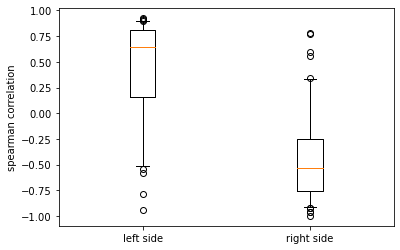

In [3]:
## plotting

##pos_corr= np.nan_to_num(pos_corr, 0)
##neg_corr = np.nan_to_num(neg_corr, 0)

fig, ax = plt.subplots()
ax.boxplot([pos_corr, neg_corr], whis = [5,95])
ax.set_xticklabels(['left side', 'right side'])
ax.set_ylabel('spearman correlation')
plt.show()

## add scatter

In [4]:
## statistics
## are the two correlations different?
print(scipy.stats.mannwhitneyu(pos_corr, neg_corr))
print(scipy.stats.ttest_ind(pos_corr, neg_corr))

## is the left side correlation greater than 0?
print(scipy.stats.ttest_1samp(pos_corr, 0, alternative='greater'))
## we can reject the null
## conclude left side correlation is positive 

## is the population correlation left less than 0?
print(scipy.stats.ttest_1samp(neg_corr, 0, alternative='less'))
## we can reject the null
## conclude right side correlation is negative

MannwhitneyuResult(statistic=5647.0, pvalue=1.3260008985561535e-17)
Ttest_indResult(statistic=12.261895366763543, pvalue=1.0329227051377565e-24)
Ttest_1sampResult(statistic=7.471611455997942, pvalue=8.56253524573405e-11)
Ttest_1sampResult(statistic=-10.06475160230521, pvalue=1.3237240972180318e-16)


<ipython-input-5-8df900cc8c53>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(df_corr_2, ignore_index = True)


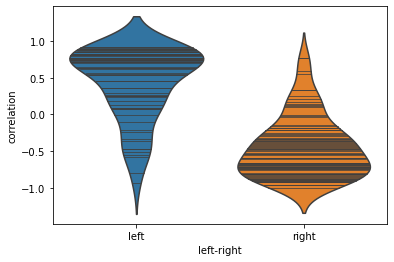

In [5]:
df_corr = pd.DataFrame(np.array([np.array(pos_corr), np.array(['left']*len(pos_corr))]).T, columns = ['correlation', 'left-right'])
df_corr_2 = pd.DataFrame(np.array([np.array(neg_corr), np.array(['right']*len(neg_corr))]).T, columns = ['correlation', 'left-right'])
df_corr = df_corr.append(df_corr_2, ignore_index = True)
df_corr["correlation"] = pd.to_numeric(df_corr["correlation"])
##sb.stripplot(x = 'left-right', y = 'correlation', data = df_corr)
##sb.boxplot(x = 'left-right', y = 'correlation', data = df_corr)
sb.violinplot(x = 'left-right', y = 'correlation', data = df_corr, inner="stick")